In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp
from osc_toolkit import *
from models import *

In [3]:
params1 = {'alpha': 10, 'beta': 10, 'theta': 0.25, 'phi': 15}
consts1 = {'lam': 0.1, 'm': 2}
init_cond = [0.1, 0, 0]
model1 = oscillation(full_FTC_first_order['model'], list(params1.values()), list(consts1.values()), init_cond, full_FTC_first_order['calc_all'])
sol1 = model1.simulate(t=5)

In [4]:
params2 = {'alpha': 3.55, 'beta': 3.25, 'theta': 0.2, 'phi': 5}
consts2 = {'lam': 0.2, 'm': 2}
init_cond = [0.1, 0, 0]
model2 = oscillation(full_FTC_first_order['model'], list(params2.values()), list(consts2.values()), init_cond, full_FTC_first_order['calc_all'])
sol2 = model2.simulate(t=5)

In [ ]:
class mixed_oscillation(oscillation):
    def __init__(self, model, params, consts, init_cond):

        # Model and parameters
        self.__model = model['model']
        self.__params = params
        self.__consts = consts
        self.__calc_all = model['calc_all']
        self.__init_cond = init_cond

        # Essential information
        self.__species = ['A2', 'S_sum', 'A', 'O']
        self.__info = model['info']

        # Experimental data
        self.__exp_data = None

In [ ]:
def full_two_thiols(t, vars, params):
    alpha1, beta1, theta1, phi1, lam1, m1, alpha2, beta2, theta2, phi2, lam2, m2 = params
    cA2, cS1, cS2, cO = vars
    r = lam1/lam2
    cM1 = cS1**m1
    cM2 = cS2**m2
    cA = 2 * (1 - cA2) - lam1 * (cS1 + cM1) - lam2 * (cS2 + cM2)
    dcA2dt = cO * cA - (theta1 + theta2) * cA2 - alpha1 * (cM1 + r * cM2) * cA2 - alpha2 * (1/r * cM1 + cM2) * cA2
    dcS1dt = theta1/lam1 * cA2 - phi1 * cS1 + alpha1/lam1 * (cM1 + r * cM2) * cA2 - beta1 * cM1
    dcS2dt = theta2/lam2 * cA2 - phi2 * cS2 + alpha2/lam2 * (1/r * cM1 + cM2) * cA2 - beta2 * cM2
    dcOdt = 1 - cO * cA
    return [dcA2dt, dcS1dt, dcS2dt, dcOdt]

In [6]:
from functools import partial

In [7]:
from scipy.integrate import solve_ivp

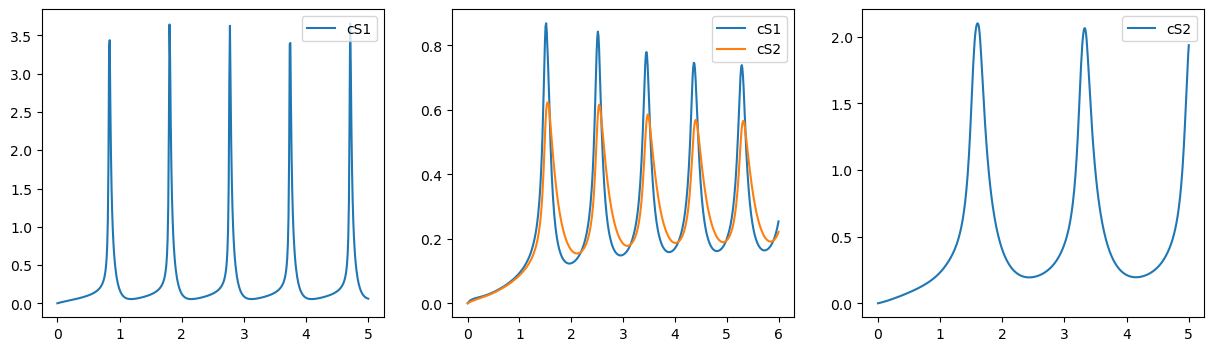

In [10]:
params1 = {'alpha': 12, 'beta': 12, 'theta': 0.25, 'phi': 15}
params2 = {'alpha': 3.55, 'beta': 3.25, 'theta': 0.2, 'phi': 5}

params = np.array(list(params1.values()) + list(consts1.values()) + list(params2.values()) + list(consts2.values()))
init_cond = [0.1, 0, 0, 0]
model_partial = partial(full_two_thiols, params=params)
t = 6
t_span = [0, t]
t_eval = np.linspace(0, t, 500)

sol = solve_ivp(model_partial, t_span, init_cond, t_eval=t_eval)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(sol1.t, sol1.y[1], label='cS1')
ax[1].plot(sol.t, sol.y[1], label='cS1')
ax[1].plot(sol.t, sol.y[2], label='cS2')
ax[2].plot(sol2.t, sol2.y[1], label='cS2')
for a in ax:
    a.legend(loc=1)